# Importing Libraries

In [56]:
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random

In [57]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])
# print(os.environ['SHELL'])


dslab


# Loading Data

Select the dataset you want to work with by setting the variable 'dataset_name'

In [58]:
def read_HSI(dataset):
    if dataset == 'Salinas':
        X = loadmat('../Datasets/Salinas/Salinas_corrected.mat')['salinas_corrected']
        y = loadmat('../Datasets/Salinas/Salinas_gt.mat')['salinas_gt']
        print(f"X shape: {X.shape}\ny shape: {y.shape}")
        return X, y
    elif dataset == 'Indian Pines':
        X = loadmat('../Datasets/IndianPines/Indian_pines_corrected.mat')['indian_pines_corrected']
        y = loadmat('../Datasets/IndianPines/Indian_pines_gt.mat')['indian_pines_gt']
        print(f"X shape: {X.shape}\ny shape: {y.shape}")
        return X, y
    
# dataset_name = 'IndianPines'
dataset_name = 'Salinas'
X, y = read_HSI(dataset=dataset_name)

if dataset_name == 'Salinas':
    class_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow',
                    'Fallow_rough_plow','Fallow_smooth','Stubble','Celery',
                    'Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green',
                    'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk',
                    'Lettuce_romaine_7wk','Vinyard_untrained','Vinyard_vertical']
elif dataset_name == 'IndianPines':
    class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill","Corn", "Grass-pasture", 
                    "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats",
                    "Soybean-notill", "Soybean-mintill", "Soybean-clean","Wheat",
                    "Woods", "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
    


X shape: (512, 217, 204)
y shape: (512, 217)


# Visualizing Dataset

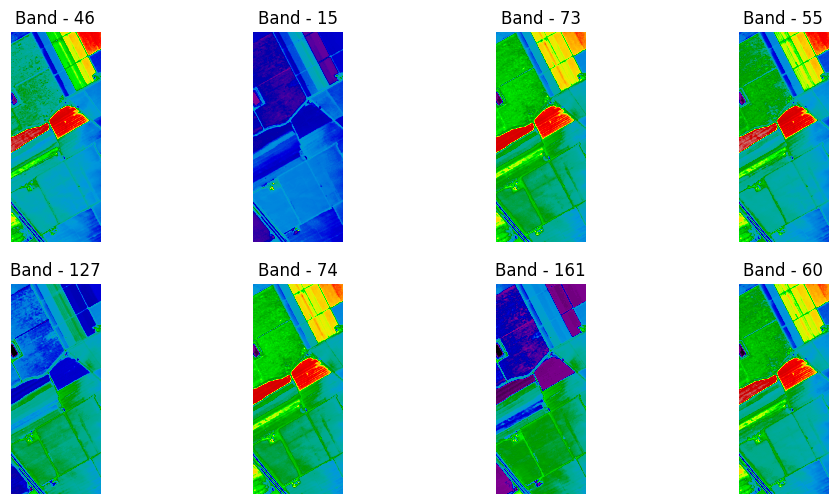

In [59]:
#Spectral bands

fig = plt.figure(figsize = (12, 6))

for i in range(1, 8+1):
    fig.add_subplot(2,4, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')

In [60]:
X.shape

(512, 217, 204)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


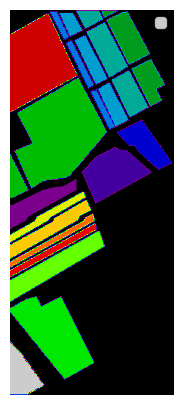

In [61]:
# Ground Truth

plt.figure(figsize=(10, 5))
plt.imshow(y, cmap='nipy_spectral')
# plt.colorbar
plt.legend()
plt.axis('off')
plt.show()

In [62]:
def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  # df.to_csv(f'./Datasets/Raw/{dataset_name}/{dataset_name}.csv')
  return df

df = extract_pixels(X, y)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111104 entries, 0 to 111103
Columns: 205 entries, band1 to class
dtypes: int16(204), uint8(1)
memory usage: 43.3 MB


In [63]:
df.iloc[:, :-1].describe()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band195,band196,band197,band198,band199,band200,band201,band202,band203,band204
count,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,...,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000
mean,372.181929,480.388321,693.751287,1156.562923,1462.129950,1533.406025,1473.193944,1634.795552,1866.721801,1930.824417,...,132.158959,116.093219,138.739181,117.048180,71.937059,104.474825,71.262025,39.304778,14.063463,22.294175
std,62.453906,80.614130,103.217542,170.676450,227.876068,260.417860,271.714302,329.998481,404.351771,445.485781,...,71.227778,63.216203,76.108928,65.012702,40.255958,59.222728,41.232828,23.280864,9.088472,13.735217
min,87.000000,86.000000,90.000000,86.000000,91.000000,91.000000,88.000000,88.000000,87.000000,86.000000,...,-3.000000,-6.000000,-2.000000,-7.000000,-5.000000,-3.000000,-6.000000,-9.000000,-8.000000,-11.000000
25%,308.000000,404.000000,604.000000,1005.000000,1260.000000,1305.000000,1240.000000,1348.000000,1514.000000,1540.000000,...,64.000000,55.000000,65.000000,55.000000,33.000000,47.000000,32.000000,18.000000,7.000000,10.000000
50%,372.000000,482.000000,721.000000,1174.000000,1496.000000,1560.000000,1512.000000,1691.000000,1936.000000,2007.000000,...,143.000000,126.000000,150.000000,127.000000,78.000000,113.000000,76.000000,42.000000,15.000000,23.000000
75%,435.000000,558.000000,745.000000,1267.000000,1617.000000,1715.000000,1664.000000,1873.000000,2157.000000,2255.000000,...,197.000000,174.000000,209.000000,177.000000,109.000000,159.000000,108.000000,60.000000,21.000000,33.000000
max,814.000000,1165.000000,1920.000000,3865.000000,5153.000000,5614.000000,5663.000000,6599.000000,7748.000000,8209.000000,...,569.000000,504.000000,608.000000,523.000000,596.000000,693.000000,745.000000,765.000000,777.000000,775.000000


# Dimensionality Reduction

In [64]:
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA


def show_random_bands(df_dr):
    fig = plt.figure(figsize = (20, 10))

    random_bands = random.sample(range(1, df_dr.shape[1]), 8)
    for i in range(1, 8+1):
        fig.add_subplot(2,4, i)
        plt.imshow(df_dr.loc[:, f'Band-{random_bands[i-1]}'].values.reshape(y.shape[0], y.shape[1]), cmap='nipy_spectral')
        plt.axis('off')
        plt.title(f'Band - {random_bands[i-1]}')

def apply_DR(method, n_components):
    if method == 'PCA':
        pca = PCA(n_components = n_components, random_state=0)
        dt = pca.fit_transform(df.iloc[:, :-1].values)
    elif method == 'FastICA':
        fast_ica = FastICA(n_components=n_components,
         random_state=0,
         whiten='unit-variance',
         max_iter=400)
        dt = fast_ica.fit_transform(df.iloc[:, :-1].values)
    dr_df = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
    dr_df.columns = [f'Band-{i}' for i in range(1,n_components+1)]+['class']

    dr_df.head()
    return dr_df

## PCA

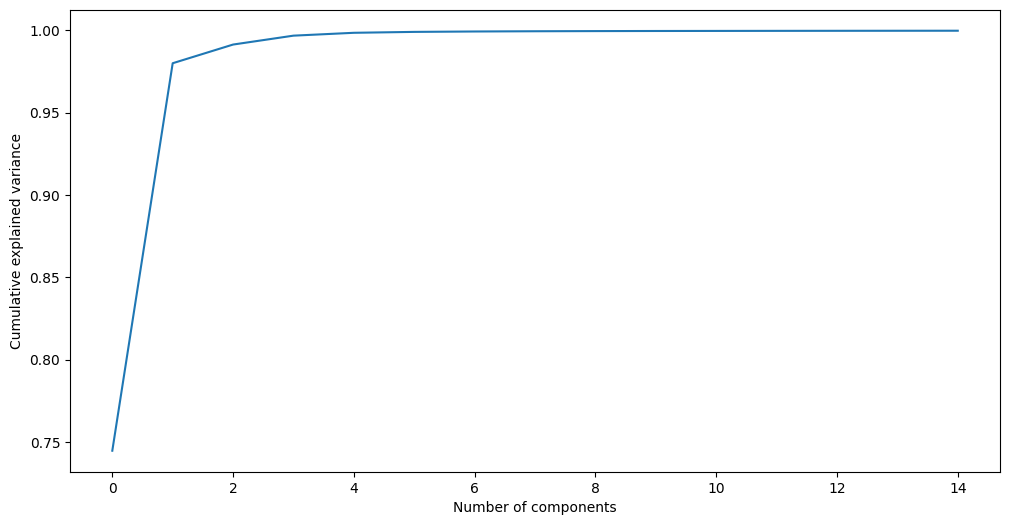

In [65]:

pca = PCA(n_components = 15) #initial test

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()


In [69]:
n_components = 50

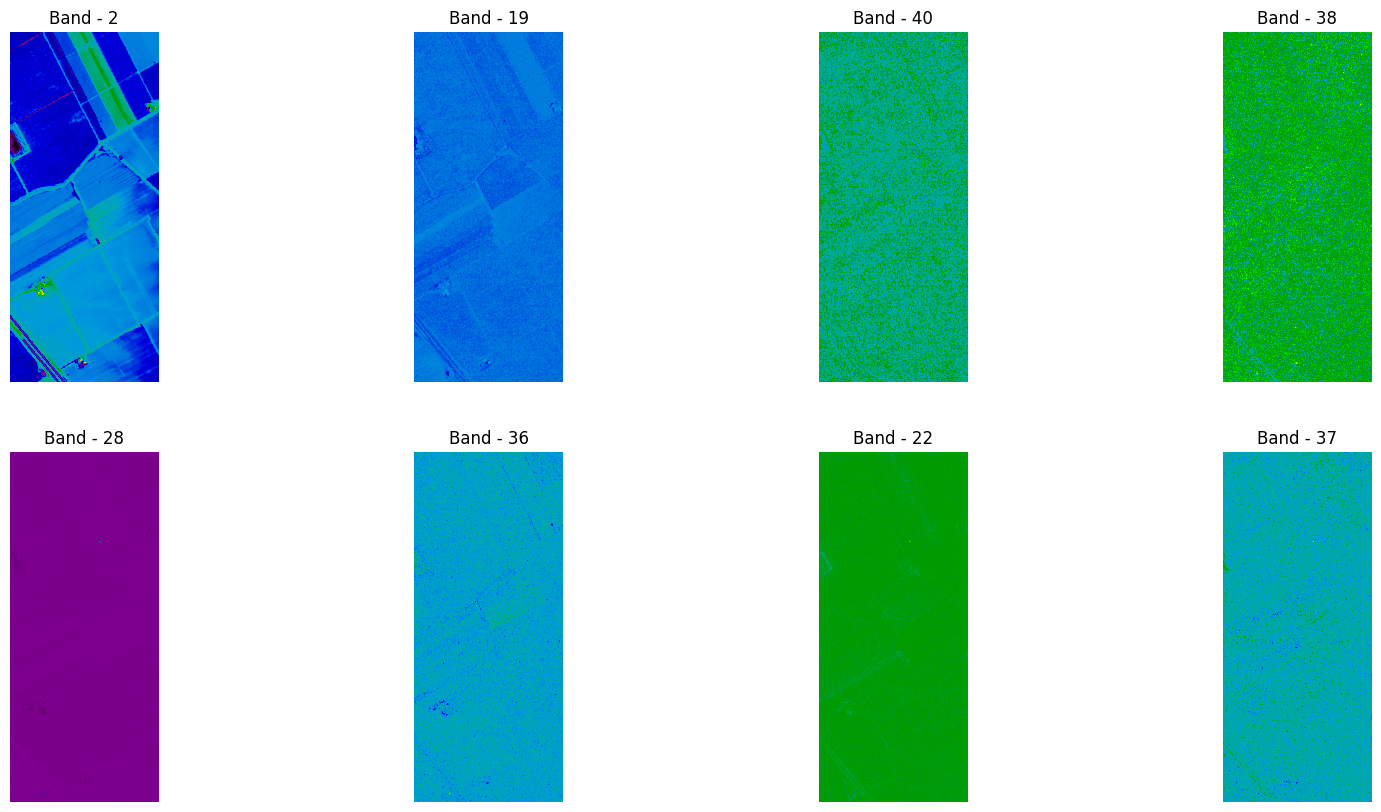

In [70]:
dr_df = apply_DR(method='PCA', n_components=n_components)
show_random_bands(dr_df)

# saving to .mat
reshaped_data = np.array([row[1][:-1] for row in dr_df.iterrows()]).reshape((X.shape[0], X.shape[1], n_components))
savemat(f'../Datasets/{dataset_name}/{dataset_name}_PCA_{n_components}.mat', {'data': reshaped_data})

## FastICA

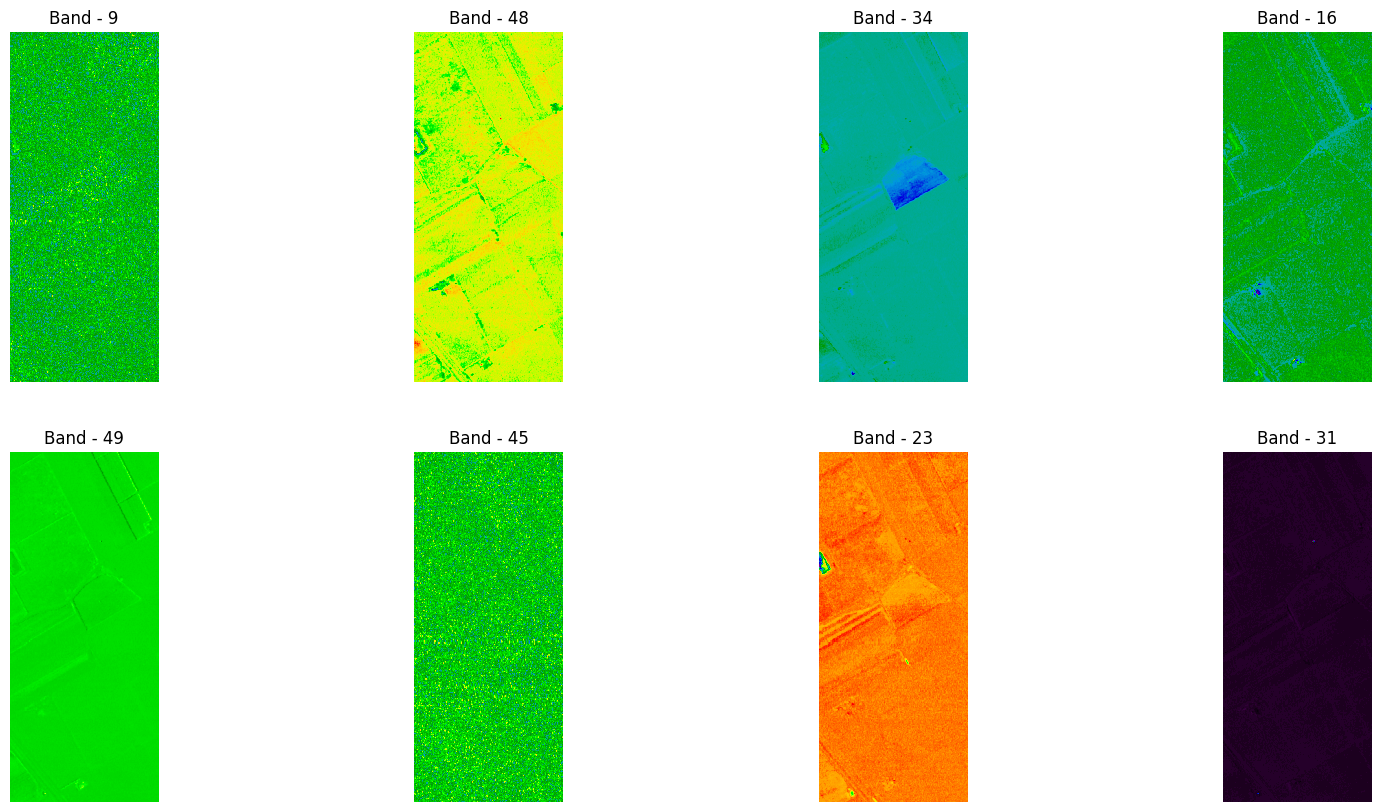

In [71]:
dr_df = apply_DR(method='FastICA', n_components=n_components)
show_random_bands(dr_df)

# saving to .mat
reshaped_data = np.array([row[1][:-1] for row in dr_df.iterrows()]).reshape((X.shape[0], X.shape[1], n_components))
savemat(f'../Datasets/{dataset_name}/{dataset_name}_FastICA_{n_components}.mat', {'data': reshaped_data})